# Tutorial 3a. Homemade one-hidden layer perceptron for binary classification

![](mlp.svg)

## This is a homework: put your names here

- `Merwan EL ASRI` (pas de binôme)

## Description

The goal of this tutorial is to build and train your first neural network *by hand* !

- To keep things as simple as possible we consider a simple *perceptron* with *one hidden layer*
- We consider a binary-classification problem which cannot be solved with a linear classifier
- We use a toy dataset which is already created for you with the `load_data()` function

The neural network will have to be **programmed and trained from scratch**, meaning that you will have to define its structure yourself, and that **you are not allowed** to use the built-in functionalities of `PyTorch` for autodifferentiation. You will have to program the forward and backward pass *yourself*, together with the gradient descent algorithm.

**Read the following instructions carefully in order to succeed**

- You are already provided with a simple python class which will constitute your neural network. 

- The constructor of this class (`__init__`) requires you to specify the following parameters (investigate the data carefully in order to know how these parameters need to be defined).
    - Number of input nodes (number of features)
    - Number of hidden units 
    - Number of output nodes

- The constructor of the neural network also requires you to allocate the weight matrices and bias vectors which will be the main components of your computational graph. For this, you can use some of the tensor operations we have seen in `tutorial2a`, in order to initialize at random the weights, for instance.

- Implementing a neural network consists in two main steps:
    - Forward-pass: computing the output of the network based on its weight matrices and bias vectors. Since we consider binary classification, we should output activations that are activated by a sigmoid
    - Backward-pass: computing how different the predictions of the network are from what should be predicted and update the parameters of the network with the backpropagation algorithm. You are already provided with a loss function in the code which requires only slight modifications.

- If you want to challenge yourself you can extend the neural network as follows:
    - add multiple hidden layers of different sizes
    - explore different non-linear activation functions
    - investigate whether the network starts overfitting

In [1]:
import numpy as np
import torch
import sklearn
from sklearn.datasets import make_gaussian_quantiles
from sklearn.model_selection import train_test_split
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt

## Simulation of the data

In [2]:
def load_data(n_samples=500):
    return make_gaussian_quantiles(
        mean=None,
        cov=0.7,
        n_samples=n_samples,
        n_features=2,
        n_classes=2,
        shuffle=True,
        random_state=42,
    )

In [3]:
gaussian_quantiles = load_data()
X, y = gaussian_quantiles

print(X[:10, :])
print(y[:10])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

[[-1.13773727  0.62436053]
 [-0.75970745 -1.18161805]
 [-0.82471758  0.42171557]
 [-0.09398039 -0.18487643]
 [-0.80731289  0.57399183]
 [ 0.67980788  1.13471182]
 [-1.70521733 -0.84342552]
 [ 1.57461467  1.12565917]
 [-0.22579357 -0.81889248]
 [ 0.97317262  0.00856159]]
[1 1 0 0 1 1 1 1 0 1]


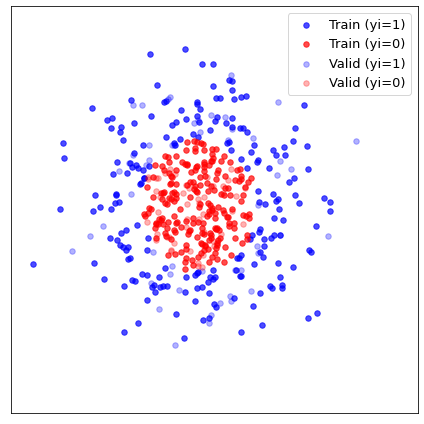

In [4]:
cm = plt.cm.RdBu
cm_bright = ListedColormap(['#FF0000', '#0000FF'])

def plot_data(X, y, xy_labels=True, label=None, **kwargs):
    X_1 = X[y == 1]
    X_0 = X[y == 0]
    if label is not None:
        plt.scatter(X_1[:, 0], X_1[:, 1], c="blue", s=30, label=label + " (yi=1)", **kwargs)
        plt.scatter(X_0[:, 0], X_0[:, 1], c="red", s=30, label=label + " (yi=0)", **kwargs)
    plt.xticks(())
    plt.yticks(())
    plt.xlim(X[:, 0].min() - 1, X[:, 0].max() + 1)
    plt.ylim(X[:, 1].min() - 1, X[:, 1].max() + 1)

plt.figure(figsize=(6, 6))
plot_data(X_train, y_train, alpha=0.7, label="Train")
plot_data(X_test, y_test, alpha=0.3, label="Valid")
plt.legend(fontsize=13)
plt.tight_layout()

## A neural network class

**QUESTION.** Implement the `forward` and `backward` methods in the following class, and fill the `__init__` and `train` methods, in order to train the one-hidden layer perceptron for binary classification. 

In [135]:
def sigmoidPrime(x):
    return torch.sigmoid(x) * (1-torch.sigmoid(x))
class NeuralNetwork:
    def __init__(self, n_in, n_hidden, n_out):
        factor = 10
        # Commentaire :  en cours on avait dit qu'en utilisant une gaussienne normale
        # il fallait multiplier par 10**-2, pour éviter l'"exploding gradient" 
        # néanmoins, multiplier par 10 permet d'obtenir une surface de décision
        # qui correspond mieux aux données d'entraînement et une AUC de 96% sur les données d'entraînement
        # J'imagine que c'est parce qu'on s'écarte encore plus de la symmétrie.
        #
        # Évidemment, on n'évite pas le problème de l'"exploding gradient" 
        # mais ce n'est pas grave, puisque les poids correspondant au modèle
        # ayant la plus faible loss sont sauvegardés

        self.n_x = n_in
        self.n_h = n_hidden
        self.n_y = n_out

        self.W1 = torch.rand(n_in, n_hidden) * factor
        self.b1 = torch.rand(n_hidden)* factor
        self.W2 = torch.rand(n_hidden, n_out) * factor
        self.b2 = torch.rand(n_out) * factor
                        
    def forward(self, X):
        self.Z1 = X.mm(self.W1) + self.b1
        self.A1 = torch.sigmoid(self.Z1)
        self.Z2 = self.A1.mm(self.W2) + self.b2 
        self.A2 = torch.sigmoid(self.Z2)
        return self.A2

    def backward(self, X, y_train):

        self.delta2 = (self.A2 - y_train)/y_train.shape[0]
        self.dL_byW2 = self.A1.t().mm(self.delta2)
        self.dL_byb2 = self.delta2.sum(axis=0)

        self.delta1 = self.delta2.mm(self.W2.t()).mul(sigmoidPrime(self.Z1))
        self.dL_byW1 = X.t().mm(self.delta1)       
        self.dL_byb1 = self.delta1.sum(axis=0)

        
    def train(self, X_train, y_train, X_valid, y_valid, epochs, learning_rate):
        self.training_loss_save = [] 
        self.validation_loss_save = [] 
        self.best_training_loss = float('inf')
        for e in range(epochs):
            
            self.forward(X_valid)
            validation_loss = -torch.sum(torch.mul(torch.log(self.A2), y_valid) + torch.mul(torch.log(1- self.A2 ),  (1 - y_valid))) / y_valid.shape[0]
            self.forward(X_train)
            training_loss = -torch.sum(torch.mul(torch.log(self.A2), y_train) + torch.mul(torch.log(1- self.A2 ),  (1 - y_train))) / y_train.shape[0]
            
            print(f"epoch = {e}/{epochs-1}  training_loss = {training_loss} validation_loss = {validation_loss} ")
            self.training_loss_save.append(training_loss)
            self.validation_loss_save.append(validation_loss)
            self.backward(X_train, y_train.unsqueeze(1) )
            
            self.W1 -= learning_rate * self.dL_byW1  
            self.b1 -= learning_rate * self.dL_byb1
            self.W2 -= learning_rate * self.dL_byW2
            self.b2 -= learning_rate * self.dL_byb2

            # sauvegarde du modèle ayant le training loss le plus bas:
            if self.best_training_loss > training_loss :
                self.best_training_loss  = training_loss
                self.b1_saved = self.b1.clone()
                self.W1_saved = self.W1.clone()
                self.b2_saved = self.b2.clone()
                self.W2_saved = self.W2.clone()
                self.bestEpoch = e
        
        # le meilleur modèle est récupéré à la fin
        self.b1 = self.b1_saved
        self.W1 = self.W1_saved
        self.b2 = self.b2_saved
        self.W2 = self.W2_saved

**QUESTION.** Train your neural network, modify your code to save the training and validation error along the gradient descent iterations and plot them. You should also print the train and validation errors during training.

In [136]:
X_train_torch = torch.from_numpy(X_train).float()
y_train_torch = torch.from_numpy(y_train).float()
X_valid_torch = torch.from_numpy(X_test).float()
y_valid_torch = torch.from_numpy(y_test).float()

nn = NeuralNetwork(n_in=2, n_hidden=32, n_out=1)

nn.train(
    X_train_torch,
    y_train_torch,
    X_valid_torch,
    y_valid_torch,
    epochs=2500,
    learning_rate=0.5
)

epoch = 0/2499  training_loss = nan validation_loss = nan 
epoch = 1/2499  training_loss = nan validation_loss = nan 
epoch = 2/2499  training_loss = nan validation_loss = nan 
epoch = 3/2499  training_loss = nan validation_loss = nan 
epoch = 4/2499  training_loss = nan validation_loss = nan 
epoch = 5/2499  training_loss = nan validation_loss = nan 
epoch = 6/2499  training_loss = nan validation_loss = nan 
epoch = 7/2499  training_loss = nan validation_loss = nan 
epoch = 8/2499  training_loss = nan validation_loss = nan 
epoch = 9/2499  training_loss = nan validation_loss = nan 
epoch = 10/2499  training_loss = nan validation_loss = nan 
epoch = 11/2499  training_loss = nan validation_loss = nan 
epoch = 12/2499  training_loss = nan validation_loss = nan 
epoch = 13/2499  training_loss = nan validation_loss = nan 
epoch = 14/2499  training_loss = nan validation_loss = nan 
epoch = 15/2499  training_loss = nan validation_loss = nan 
epoch = 16/2499  training_loss = nan validation_lo

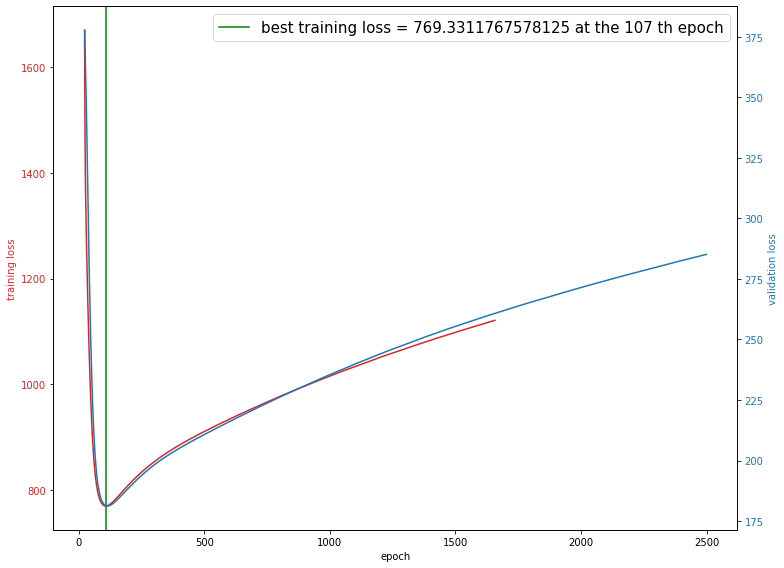

In [140]:
ord_train = [ tensor.item() for tensor in nn.training_loss_save]
ord_valid = [ tensor.item() for tensor in nn.validation_loss_save]
abs = np.array(range(0, len(nn.training_loss_save)))

fig, ax1 = plt.subplots()
_= ax1.figure.set_size_inches(11, 8)

color = 'tab:red'
_= ax1.set_xlabel('epoch')
_= ax1.set_ylabel('training loss', color=color)
_= ax1.plot(abs, ord_train, color=color)
_= ax1.tick_params(axis='y', labelcolor=color)
_= plt.axvline(x=nn.bestEpoch, color="green", label=f"best training loss = {nn.best_training_loss} "\
                                                    f"at the {nn.bestEpoch} th epoch")
_= plt.legend(prop={'size': 15})

ax2 = ax1.twinx()

color = 'tab:blue'
ax2.set_ylabel('validation loss', color=color)  
ax2.plot(abs, ord_valid, color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()
plt.show()

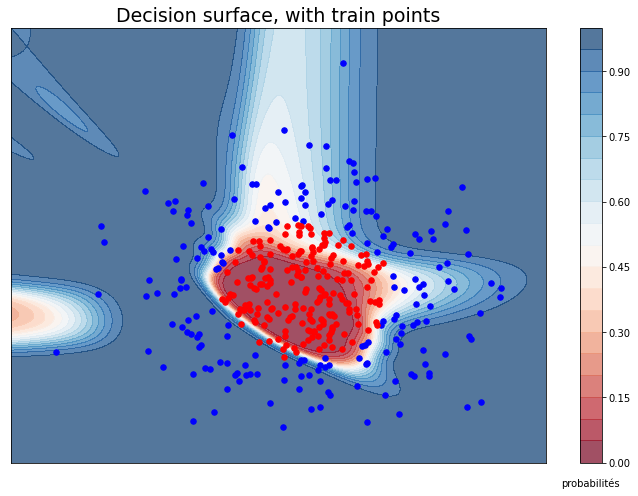

In [159]:
from matplotlib.colors import ListedColormap
def decisionSurface(X_torch, X_numpy, y_train, string):
    ax = plt.subplot(1, 1, 1)
    _= ax.figure.set_size_inches(12, 8)

    x_min, x_max = X_torch[:, 0].min() - .5, X_torch[:, 0].max() + .5
    y_min, y_max = X_torch[:, 1].min() - .5, X_torch[:, 1].max() + .5

    h = 0.01
    levels = 20
    cm = plt.cm.RdBu
    cm_bright = ListedColormap(['#FF0000', '#0000FF'])

    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                            np.arange(y_min, y_max, h))    
    abs, ord = xx.flatten(), yy.flatten()
    abs, ord = abs.reshape((len(abs), 1)), ord.reshape((len(ord), 1))
    gridToPredict = torch.from_numpy(np.hstack((abs,ord))).float()
    Z = nn.forward(gridToPredict).detach().numpy()
    Z = Z.reshape(xx.shape)
    ct = ax.contourf(xx, yy, Z, cmap=cm, alpha=.7, levels=levels)
    _= cbar = plt.colorbar(ct)
    _= cbar.ax.set_xlabel("\nprobabilités")


    X_1 = X_numpy[y_train == 1]
    X_0 = X_numpy[y_train == 0]
    _= plt.scatter(X_1[:, 0], X_1[:, 1], c="blue", s=30, label=r"$y_i=1$")
    _= plt.scatter(X_0[:, 0], X_0[:, 1], c="red", s=30, label=r"$y_i=-1$")
    _= ax.set_xticks(())
    _= ax.set_yticks(())

    _= ax.set_xlim(x_min, x_max)
    _= ax.set_ylim(y_min, y_max)
    _= ax.set_title(f"Decision surface, with {string} points", fontsize=19)
decisionSurface(X_train_torch, X_train, y_train, "train")

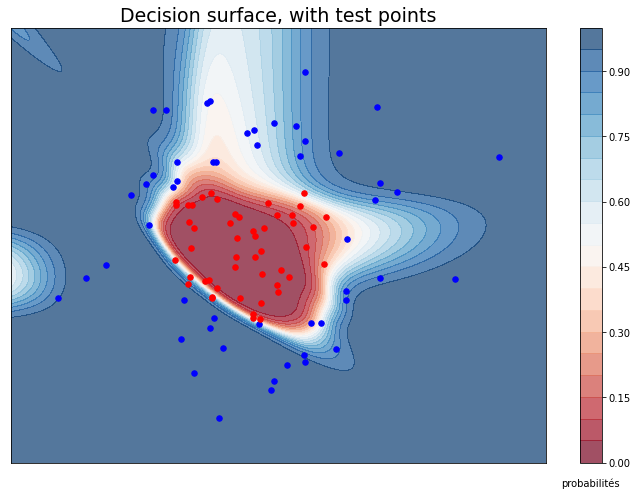

In [167]:
decisionSurface(X_valid_torch, X_test, y_test, "test")

## Assessment of your model

**QUESTION.** Use and modify the plotting functions from this notebook and the ones from `tutorial01` in order to plot the data together with the **predicted probabilities** of your neural network for inputs in a grid covering the input features space (as we did in `tutorial01`). Also, display on the plot the AUC-ROC metric obtained by your neural net.

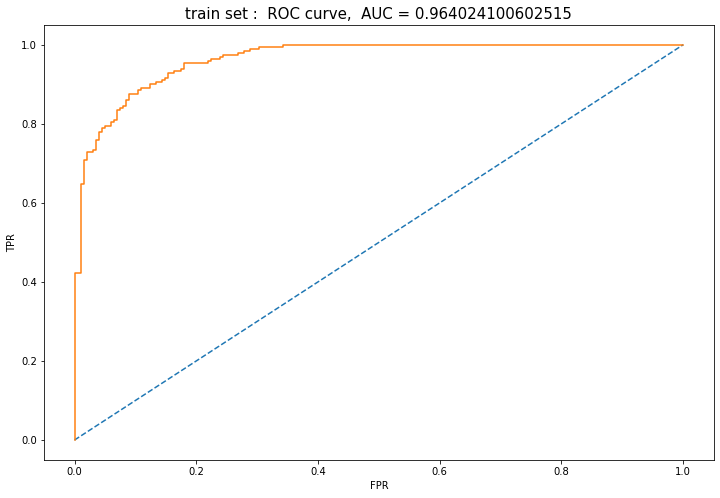

In [164]:
from sklearn.metrics import roc_auc_score,  roc_curve
def plotROC(X_torch,y , string) :
    y_score = nn.forward(X_torch).detach().numpy()
    AUC = roc_auc_score(y_true=y, y_score=y_score)
    fpr, tpr, _=roc_curve(y_true=y, y_score=y_score)

    xeqy = np.linspace(0,1,40)
    _= plt.figure(figsize=(12, 8))
    _= plt.plot(xeqy, xeqy, linestyle='--')
    _= plt.plot(fpr, tpr)
    _= plt.title(f"{string} set :  ROC curve,  AUC = {AUC}", fontsize= 15)
    _= plt.xlabel("FPR")
    _= plt.ylabel("TPR")
plotROC(X_train_torch, y_train, "train")

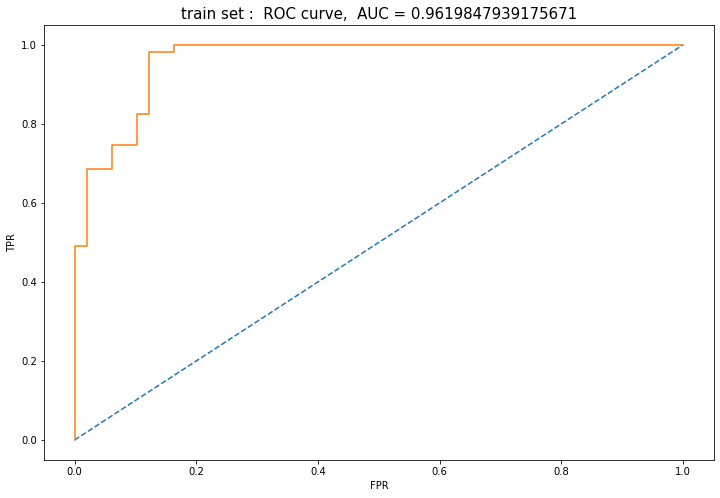

In [166]:
plotROC(X_valid_torch, y_test, "train")